Imports

In [1]:
from ultralytics import YOLO
import yaml, os, sys, glob, random
import torch
print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())

PyTorch: 2.5.1+cu121 | CUDA available: True


Data Description

In [2]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, "dataset")
DATA_YAML = os.path.join(data_dir, "data.yaml")
assert os.path.exists(DATA_YAML), f"data.yaml not found at {DATA_YAML}"

with open(DATA_YAML, "r") as f:
    data_cfg = yaml.safe_load(f)

print("Classes:", data_cfg.get("names"))

Classes: ['fish']


In [3]:
# Collect a few images from the train split
names = data_cfg.get("names", [])
train_path = os.path.join(data_dir, "train//images")
img_exts = ("*.jpg")
train_imgs = []
for ext in img_exts:
    train_imgs.extend(glob.glob(os.path.join(train_path, ext)))
train_imgs.sort()

print(f"Found {len(train_imgs)} train images")
assert len(train_imgs) > 0, "No training images found. Check data.yaml paths."

Found 462 train images


Show some sample images

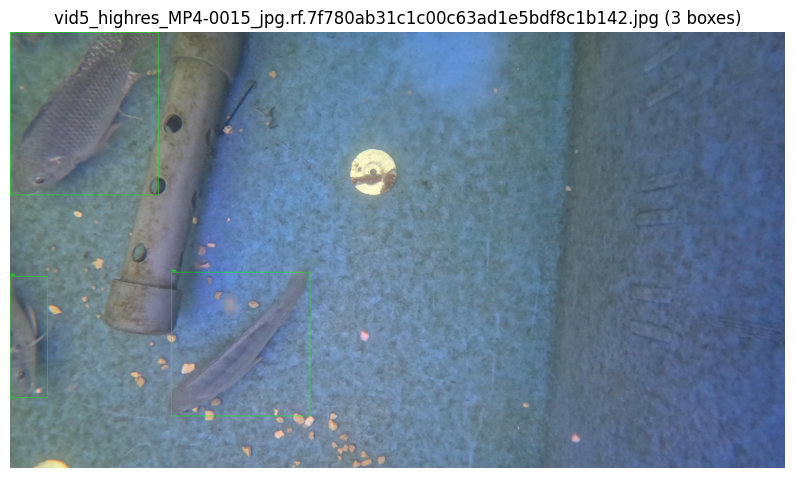

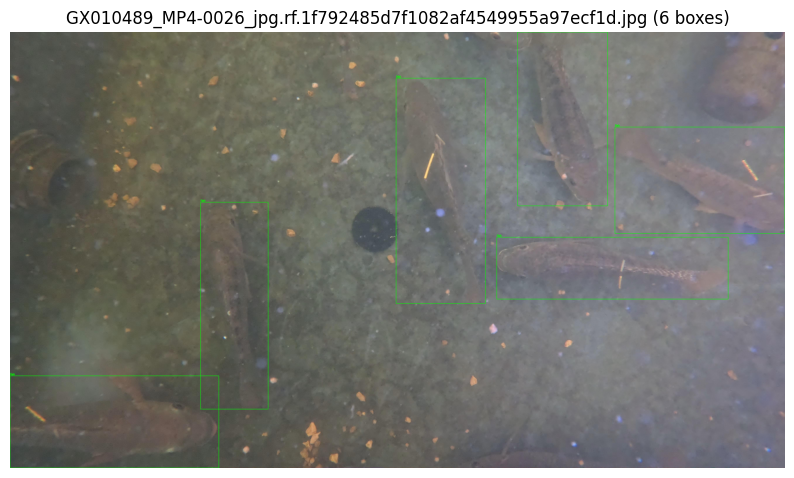

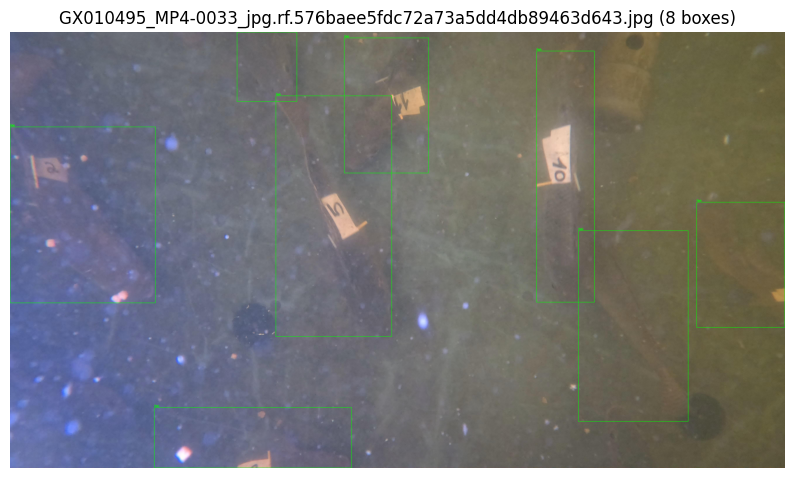

In [4]:
import os, cv2, random
import matplotlib.pyplot as plt

def img_to_label_path(img_path: str) -> str:
    """Map each image to its corresponding YOLO label file."""
    base, fname = os.path.split(img_path)
    root = os.path.dirname(base)

    # Prefer replacing 'images' with 'labels'
    if "images" in base:
        label_path = base.replace("images", "labels")
        candidate = os.path.join(label_path, os.path.splitext(fname)[0] + ".txt")
        if os.path.exists(candidate):
            return candidate

    # Fallbacks
    c1 = os.path.join(root, "labels", os.path.splitext(fname)[0] + ".txt")
    c2 = os.path.join(base, os.path.splitext(fname)[0] + ".txt")
    return c1 if os.path.exists(c1) else c2


def read_yolo_labels(txt_path):
    """Read YOLOv8 detection labels: cls x_center y_center width height (normalized)."""
    boxes = []
    if os.path.exists(txt_path):
        with open(txt_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls = int(float(parts[0]))
                    xc, yc, w, h = map(float, parts[1:5])
                    boxes.append([cls, xc, yc, w, h])
    return boxes


def yolo_to_xyxy(cls, xc, yc, w, h, W, H):
    """Convert normalized YOLO box to pixel coordinates."""
    x1 = int((xc - w / 2) * W)
    y1 = int((yc - h / 2) * H)
    x2 = int((xc + w / 2) * W)
    y2 = int((yc + h / 2) * H)
    return cls, x1, y1, x2, y2


def show_with_boxes(img_path):
    """Show image with YOLO bounding boxes."""
    img = cv2.imread(img_path)
    assert img is not None, f"Failed to read image: {img_path}"
    H, W = img.shape[:2]
    lbl = img_to_label_path(img_path)
    boxes = read_yolo_labels(lbl)

    vis = img.copy()
    for b in boxes:
        cls, x1, y1, x2, y2 = yolo_to_xyxy(b[0], b[1], b[2], b[3], b[4], W, H)
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cls_name = names[cls] if 0 <= cls < len(names) else str(cls)
        cv2.putText(vis, cls_name, (x1, max(0, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 7))
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{os.path.basename(img_path)} ({len(boxes)} boxes)")
    plt.show()


# --- Run visualization for a few random samples ---
sample_imgs = random.sample(train_imgs, min(3, len(train_imgs)))
for p in sample_imgs:
    show_with_boxes(p)


Train and log to wandb

In [10]:
from ultralytics import YOLO
import wandb, os
import glob

def wandb_callback(trainer):
    epoch = trainer.epoch + 1
    current_lr = trainer.optimizer.param_groups[0]['lr']

    # 1. Train Losses
    train_box_loss = trainer.tloss[0].item()
    train_cls_loss = trainer.tloss[1].item()
    train_dfl_loss = trainer.tloss[2].item()

    # 2. Val Losses
    val_losses = trainer.validator.loss_items
    val_box_loss = val_losses[0].item()
    val_cls_loss = val_losses[1].item()
    val_dfl_loss = val_losses[2].item()

    # 3. Metrics
    metrics = trainer.metrics
    val_precision = metrics.get("metrics/precision(B)", 0)
    val_recall    = metrics.get("metrics/recall(B)", 0)
    val_map50     = metrics.get("metrics/mAP50(B)", 0)
    val_map50_95  = metrics.get("metrics/mAP50-95(B)", 0)

    # dictionary construction
    log_dict = {
        "epoch": epoch,
        "lr": current_lr,
        "train/box_loss": train_box_loss,
        "train/cls_loss": train_cls_loss,
        "train/dfl_loss": train_dfl_loss,
        "val/box_loss": val_box_loss,
        "val/cls_loss": val_cls_loss,
        "val/dfl_loss": val_dfl_loss,
        "val/precision": val_precision,
        "val/recall": val_recall,
        "val/mAP50": val_map50,
        "val/mAP50-95": val_map50_95,
    }

    # validation image
    image_files = sorted(glob.glob(f"{trainer.save_dir}/*_pred.jpg"))
    if image_files:
        # last image
        latest_image = image_files[-1]
        log_dict["val_prediction_sample"] = wandb.Image(latest_image, caption=f"Epoch {epoch}")

    # Wanbe send
    wandb.log(log_dict)

# --- login to your account ---
os.environ["WANDB_API_KEY"] = "68591fc7177da3394b90d1c3d2ef0183d85215ab"
wandb.login(key=os.environ["WANDB_API_KEY"])

# --- initialize your W&B run (optional, for custom naming) ---
wandb.init(project="fish_yolo_project", name="fish_yolo_exp1")

# --- train YOLOv8 ---
model = YOLO("yolov8s.pt")
model.add_callback("on_fit_epoch_end", wandb_callback)
results  = model.train(
    data=DATA_YAML,
    epochs=30,
    imgsz=640,
    batch=16,
    device=0,
    patience=10
)

wandb.finish()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\ndvam\_netrc


New https://pypi.org/project/ultralytics/8.3.229 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.217  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\ndvam\PycharmProjects\train_yolo_for_fish_detection\dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mos

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
lr,▃▅▇██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train/box_loss,█▆▆▆▆▆▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁
train/cls_loss,█▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/dfl_loss,█▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁
val/mAP50,▆▅▁▆▆▇▇▇▇▇█▇███████████████████
val/mAP50-95,▅▄▁▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇█▇██████████
val/precision,▅▄▁▅▅▅▆▆▇▇▇▆▇▇▆▇▇▇▇▇▇█▇▇██▇▇▇▇▇
val/recall,▅▄▁▆▆▇▇▇▇▆▇▇▇▇██▇█▇▇▇▇███▇█████
epoch,30
lr,9e-05


# Test over the test set

In [6]:
# 1. Path to your data configuration file
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, "dataset")
DATA_YAML = os.path.join(data_dir, "data.yaml")

# 2. Path to your trained model checkpoint (e.g., from 'runs/detect/train/weights/best.pt')
TRAINED_MODEL_PATH = os.path.join(base_dir, "best.pt")

# 3. Device to run the test on
DEVICE = 0

# --- 1. Load Trained Model ---
try:
    model = YOLO(TRAINED_MODEL_PATH)
except Exception as e:
    print(f"Error loading model from {TRAINED_MODEL_PATH}. Please check the path.")
    print(e)
    # Exiting the script if the model can't be loaded
    exit()

# --- 2. Run Evaluation on the Test Set ---
print("Starting evaluation on the test split...")
# The 'val' method performs evaluation. By setting 'split' to 'test',
# YOLO uses the test set defined in the DATA_YAML file.
metrics = model.val(
    data=DATA_YAML,
    imgsz=640,
    split='test',  # Crucially, this targets the test split
    device=DEVICE,
    # Setting project/name ensures the results are saved locally (e.g., in runs/detect/)
    project='yolo_test_runs',
    name='final_test'
)

# --- 3. Print Final Metrics ---
# The Ultralytics 'val' method returns a Metrics object containing the results.
print("\n--- Final Test Metrics ---")
print(f"Test mAP50: {metrics.box.map50}")
print(f"Test mAP50-95: {metrics.box.map}")
# CORRECTED: Using metrics.box.p for Precision
print(f"Test Precision: {metrics.box.p}")
# CORRECTED: Using metrics.box.r for Recall
print(f"Test Recall: {metrics.box.r}")
print(f"Inference Speed (ms/img): {metrics.speed['inference']}")

# Print the directory where Ultralytics saves the results (e.g., confusion matrix, predictions)
print(f"\nDetailed results saved to: {metrics.save_dir}")

Starting evaluation on the test split...
Ultralytics 8.3.217  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 424.4225.3 MB/s, size: 778.3 KB)
val: Scanning C:\Users\ndvam\PycharmProjects\train_yolo_for_fish_detection\dataset\test\labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 55/55  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.9it/s 4.3s0.7ss
                   all         55        301      0.958      0.953      0.989      0.786
Speed: 2.2ms preprocess, 11.4ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to C:\Users\ndvam\PycharmProjects\train_yolo_for_fish_detection\yolo_test_runs\final_test5

--- Final Test Metrics ---
Test mAP50: 0.9891726474433212
Test mAP50-95: 0.786049366205905
Test Precision: [0.9

Test specific image

In [72]:
import cv2
import os
import yaml
from ultralytics import YOLO

# 1. Path to your data configuration file
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, "dataset")
DATA_YAML = os.path.join(data_dir, "data.yaml")

# 2. Path to your trained model checkpoint (e.g., from 'runs/detect/train/weights/best.pt')
TRAINED_MODEL_PATH = os.path.join(base_dir, "best.pt")

# Which test image to show
IMAGE_INDEX_TO_SHOW = 55


# Bounding boxes colors - (BGR)
COLOR_GT = (0, 255, 0)     #  Green -  Ground Truth
COLOR_PRED = (0, 0, 255)   # Red - Prediction

def get_paths(data_yaml_path):
    # Loadinf Yaml file
    with open(data_yaml_path, 'r', encoding='utf-8') as f:
        data_config = yaml.safe_load(f)

    test_images_path = os.path.normpath(os.path.join(data_dir+ "\\test\\images"))
    test_labels_path = test_images_path.replace('images', 'labels')

    if not os.path.isdir(test_images_path):
        raise NotADirectoryError(f": Test images path have not been found {test_images_path}")

    class_names = data_config['names']
    return test_images_path, test_labels_path, class_names

def load_gt_boxes(label_path, img_w, img_h):
    """Convert GT to pixel"""
    gt_boxes = []
    if not os.path.exists(label_path):
        return gt_boxes

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        try:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_c, y_c, w_n, h_n = map(float, parts[1:])

            box_w = w_n * img_w
            box_h = h_n * img_h
            x1 = int((x_c * img_w) - (box_w / 2))
            y1 = int((y_c * img_h) - (box_h / 2))
            x2 = int(x1 + box_w)
            y2 = int(y1 + box_h)
            gt_boxes.append((class_id, x1, y1, x2, y2))
        except Exception as e:
            print(f": Error {line} - {e}")
    return gt_boxes

def draw_boxes(image, gt_boxes, pred_boxes, class_names):
    """Drae bouding boxes"""
    # 1. GT
    for box in gt_boxes:
        class_id, x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), COLOR_GT, 5)
        label = f"GT: {class_names[class_id]}"
        cv2.putText(image, label, (x1, y1 - 150), cv2.FONT_HERSHEY_SIMPLEX, 5, COLOR_GT, 4)

    # 2. PRED
    for box in pred_boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        x1, y1, x2, y2 = xyxy
        conf = box.conf[0].cpu().numpy()
        class_id = int(box.cls[0].cpu().numpy())

        cv2.rectangle(image, (x1, y1), (x2, y2), COLOR_PRED, 5)
        label = f"Pred: {class_names[class_id]} ({conf:.2f})"
        cv2.putText(image, label, (x1, y1 - 50), cv2.FONT_HERSHEY_SIMPLEX, 5, COLOR_PRED, 4)
    return image

def main():
    """main """
    if IMAGE_INDEX_TO_SHOW <= 0:
        print("שגיאה: אינדקס התמונה חייב להיות 1 או יותר.")
        return

    try:
        # --- 1. טעינת נתיבים ושמות מחלקות ---
        img_dir, lbl_dir, classes = get_paths(DATA_YAML)

        # --- 2. מציאת התמונה הרצויה ---
        image_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        if not image_files:
            print(f"שגיאה: לא נמצאו קבצי תמונות בתיקייה: {img_dir}")
            return
        if IMAGE_INDEX_TO_SHOW > len(image_files):
            print(f"שגיאה: האינדקס ({IMAGE_INDEX_TO_SHOW}) גדול ממספר התמונות ({len(image_files)}).")
            print(f"האינדקס המקסימלי הוא {len(image_files)}.")
            return

        img_name = image_files[IMAGE_INDEX_TO_SHOW - 1]
        img_path = os.path.join(img_dir, img_name)

        # --- 3. טעינת תמונה ותיוגי GT ---
        img = cv2.imread(img_path)
        if img is None:
            print(f"שגיאה בטעינת התמונה: {img_path}")
            return

        h, w, _ = img.shape
        lbl_name = os.path.splitext(img_name)[0] + '.txt'
        lbl_path = os.path.join(lbl_dir, lbl_name)
        gt_boxes = load_gt_boxes(lbl_path, w, h)

        # --- 4. טעינת מודל והרצת זיהוי ---
        print(f"טוען מודל מ: {TRAINED_MODEL_PATH}")
        model = YOLO(TRAINED_MODEL_PATH)

        print(f"מריץ זיהוי על תמונה: {img_name} (אינדקס {IMAGE_INDEX_TO_SHOW})")
        # אפשר לשנות את סף ה-conf כאן אם רוצים
        results = model.predict(img_path, conf=0.25)
        pred_boxes = results[0].boxes

        # --- 5. ציור התיבות ---
        output_image = draw_boxes(img.copy(), gt_boxes, pred_boxes, classes)

        # --- 6. שמירה והצגה ---
        output_filename = f"comparison_{img_name}"
        cv2.imwrite(output_filename, output_image)
        print(f"\n--- הצלחה! ---")
        print(f"התמונה נוצרה ונשמרה בהצלחה בשם: {output_filename}")
        print(f"זיהויים (אדום): {len(pred_boxes)} | תיוגים (ירוק): {len(gt_boxes)}")

        # --- חדש: הצגת התמונה בחלון קופץ ---
        print("מציג תמונה בחלון קופץ... לחץ על מקש כלשהו כדי לסגור.")
        # שינוי גודל תצוגה אם התמונה גדולה מדי למסך
        max_h, max_w = 800, 1200
        scale = min(max_h / output_image.shape[0], max_w / output_image.shape[1], 1)
        if scale < 1:
            display_img = cv2.resize(output_image, (0, 0), fx=scale, fy=scale)
        else:
            display_img = output_image

        cv2.imshow("GT vs Prediction (Press any key to close)", display_img)
        cv2.waitKey(0) # ממתין ללחיצת מקש
        cv2.destroyAllWindows() # סוגר את כל החלונות

    except FileNotFoundError as e:
        print(f"\nשגיאת קובץ: {e}")
        print("אנא ודא שהנתיבים בראש הקובץ (DATA_YAML, TRAINED_MODEL_PATH) נכונים.")
    except Exception as e:
        print(f"\nאירעה שגיאה בלתי צפויה: {e}")

# הרצה של הפונקציה הראשית כאשר מריצים את הקובץ
if __name__ == "__main__":
    main()

טוען מודל מ: C:\Users\ndvam\PycharmProjects\train_yolo_for_fish_detection\best.pt
מריץ זיהוי על תמונה: vid5_highres_MP4-0063_jpg.rf.69c2b16315b55b1dd42d24ac2dfb7cf1.jpg (אינדקס 55)

image 1/1 C:\Users\ndvam\PycharmProjects\train_yolo_for_fish_detection\dataset\test\images\vid5_highres_MP4-0063_jpg.rf.69c2b16315b55b1dd42d24ac2dfb7cf1.jpg: 384x640 6 fishs, 46.6ms
Speed: 3.9ms preprocess, 46.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

--- הצלחה! ---
התמונה נוצרה ונשמרה בהצלחה בשם: comparison_vid5_highres_MP4-0063_jpg.rf.69c2b16315b55b1dd42d24ac2dfb7cf1.jpg
זיהויים (אדום): 6 | תיוגים (ירוק): 5
מציג תמונה בחלון קופץ... לחץ על מקש כלשהו כדי לסגור.
